# Notes

- There are two sets for this, one from a [2014 publication](https://doi.org/10.1016/j.cub.2014.09.072), one from a [2016 publication](https://elifesciences.org/articles/16965)
- The 2016 publication data contains 4 mutations at 3 subsequent and 1 "far off" sites (V39, D40, G41 and V54). Fittness is measured in terms of binding ability. Sequence length is supposed to be "56 amino acids in total")

#### First idea
- From the [2016 publication](https://elifesciences.org/articles/16965), an excel can be downloaded [from the supplement](https://doi.org/10.7554/eLife.16965.024). If the WT residues align to the WT PDB sequencce found through the 2014 paper (below), then we are a go.


#### Second idea
- For the 2014 publication, the data is in the supplements of the manuscript. At the time of writing this, the link was: https://www.cell.com/cms/10.1016/j.cub.2014.09.072/attachment/3a36211d-bddd-43e3-bf42-a6721f93a18b/mmc2.xlsx
- The XLS contains one sheet with double, single and WT reads. Parsing the RAW excel in pandas ain't an option, so I copy pasted the relevant tables in separate sheets of the original excel file
- In the excel, the fittness for single mutations is weirdly duplicated in the double mutations and not expressed in the single mutations counts. As such, I will extract all data from the double counts after some verification

##### Third idea
- After a brief sanity check, the data in the excel file was inconsistent. E.g., as possible amino acid positions, it listead floating point values:
  ```
  [in]  list(map(lambda x: print(x), doubles['Mut1 Position'].unique()))
  
  [out] 2
        3
        4
        Mut1 Position
        4.61002624942922
        4.61020016743552
        ...
  ```
- After doing some digging, it seems there's a repo available by the second author (first of the 2016 print): https://github.com/wchnicholas/DoubleMutFit2DDG
- This repo is linked to another [2015 paper](https://onlinelibrary.wiley.com/doi/full/10.1002/pro.2840), which computes ΔΔG not as a function of a library.
- After further digging, a csv-like formatted set of single and double mutations is available here: https://github.com/wchnicholas/DoubleMutFit2DDG/tree/master/result
- From here, one has to compute the fittness scores by hand for singles and doubles.
- Based on Fig 1 fitness is computed as `SelectionCount(WT) + SelectionCount(Mut) / InputCount(WT) + InputCount(Mut)`
- WT counts are:
  ```
        InputCount    SelectionCount(SumOfTriplicates)
    WT	1759616	      3041819
  ```

In [1]:
import random
import matplotlib.pyplot as plt

from copy import deepcopy
from pathlib import Path

from pandas import read_csv, read_excel
from sklearn.model_selection import train_test_split

In [2]:
data_path = Path('') / '..' / 'data' / 'gb1'
split_path = Path('') / '..' / 'splits' / 'gb1'

In [3]:
reference_sequence = """
MQYKLILNGKTLKGETTTEAVDAATAEKVFKQYANDNGVDGEWTYDDATKTFTVTELEVLFQGPLDPNSM
ATYEVLCEVARKLGTDDREVVLFLLNVFIPQPTLAQLIGALRALKEEGRLTFPLLAECLFRAGRRDLLRD
LLHLDPRFLERHLAGTMSYFSPYQLTVLHVDGELCARDIRSLIFLSKDTIGSRSTPQTFLHWVYCMENLD
LLGPTDVDALMSMLRSLSRVDLQRQVQTLMGLHLSGPSHSQHYRHTPLEHHHHHH
""".replace("\n", "")

region = (2,56)

## 2014 publication

In [4]:
singles_path = data_path / 'SingleSub.txt'
doubles_path = data_path / 'DoubleSub.txt'

In [5]:
singles = read_csv(singles_path, sep="\t")

In [6]:
singles[:3]

,Substitution-WTaa,Substitution-Pos,Substitution-Mutaa,InputCount,SelectionCount(SumOfTriplicates)
0,T,16,R,106367,184675
1,T,16,S,71248,69455
2,T,16,P,90794,66331


In [7]:
sequence_positions = singles[['Substitution-WTaa', 'Substitution-Pos']].drop_duplicates().sort_values(by="Substitution-Pos")

In [8]:
reference_region = "".join(sequence_positions["Substitution-WTaa"].values)

In [9]:
print(reference_region)

QYKLILNGKTLKGETTTEAVDAATAEKVFKQYANDNGVDGEWTYDDATKTFTVTE


This sequence has 100% identity and coverage to: https://www.ncbi.nlm.nih.gov/protein/5LDE_A?report=genbank&log$=protalign&blast_rank=1&RID=H7XZK6PV016, which is a PDB structure. It starts at UniProt pos 2 and ends at pos 56. As "whole sequences" are preferred (protein LMs trained on those, usually), I extract the FASTA:

```
>pdb|5LDE|A Chain A, Immunoglobulin G-binding protein G,Viral FLICE protein
MQYKLILNGKTLKGETTTEAVDAATAEKVFKQYANDNGVDGEWTYDDATKTFTVTELEVLFQGPLDPNSM
ATYEVLCEVARKLGTDDREVVLFLLNVFIPQPTLAQLIGALRALKEEGRLTFPLLAECLFRAGRRDLLRD
LLHLDPRFLERHLAGTMSYFSPYQLTVLHVDGELCARDIRSLIFLSKDTIGSRSTPQTFLHWVYCMENLD
LLGPTDVDALMSMLRSLSRVDLQRQVQTLMGLHLSGPSHSQHYRHTPLEHHHHHH
```

This further led to the discovery of [P06654](https://www.uniprot.org/uniprot/P06654/:

```
>sp|P06654|SPG1_STRSG Immunoglobulin G-binding protein G OS=Streptococcus sp. group G OX=1320 GN=spg PE=1 SV=1
MEKEKKVKYFLRKSAFGLASVSAAFLVGSTVFAVDSPIEDTPIIRNGGELTNLLGNSETT
LALRNEESATADLTAAAVADTVAAAAAENAGAAAWEAAAAADALAKAKADALKEFNKYGV
SDYYKNLINNAKTVEGIKDLQAQVVESAKKARISEATDGLSDFLKSQTPAEDTVKSIELA
EAKVLANRELDKYGVSDYHKNLINNAKTVEGVKELIDEILAALPKTDTYKLILNGKTLKG
ETTTEAVDAATAEKVFKQYANDNGVDGEWTYDDATKTFTVTEKPEVIDASELTPAVTTYK
LVINGKTLKGETTTKAVDAETAEKAFKQYANDNGVDGVWTYDDATKTFTVTEMVTEVPGD
APTEPEKPEASIPLVPLTPATPIAKDDAKKDDTKKEDAKKPEAKKDDAKKAETLPTTGEG
SNPFFTAAALAVMAGAGALAVASKRKED
```

However, in the UniProt sequence, the start (298) is a T instead of a Q. I'll thus pick the PDB sequence

In [10]:
assert(reference_sequence[region[0]-1:region[1]] == reference_region)

In [11]:
# SelectionCount(WT) + SelectionCount(Mut) / InputCount(WT) + InputCount(Mut)

WT = {
    'input_count': 1759616,
    'selection_count': 3041819
}

def get_fittness(row):
    return (
        (row['SelectionCount(SumOfTriplicates)'] + WT['selection_count']) / 
        (row['InputCount'] + WT['input_count'])
    )

In [12]:
singles['fittness'] = singles.apply(get_fittness, axis=1)

<AxesSubplot:>

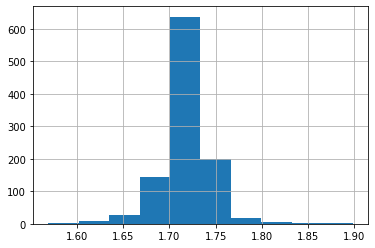

In [13]:
singles.fittness.hist()

In [14]:
doubles = read_csv(doubles_path, sep="\t")

In [15]:
doubles[:3]

,Substitution1-WTaa,Substitution1-Pos,Substitution1-Mutaa,Substitution2-WTaa,Substitution2-Pos,Substitution2-Mutaa,InputCount,SelectionCount(SumOfTriplicates),ExpectedFit,Sub1fit,Sub2fit
0,K,31,R,T,53,K,566,190,0.223,0.234,0.953
1,K,31,R,T,53,I,167,47,0.177,0.234,0.759
2,K,31,R,T,53,H,345,72,0.158,0.234,0.678


In [16]:
# --> Stopped here in favour of the 2016 publication. May want to resmue on this set at a later point

# 2016 publication

In [17]:
four_mutations_data = read_excel(data_path / "elife-16965-supp1-v4.xlsx")

/Users/chdallago/miniconda3/envs/bio-benchmarks/lib/python3.8/site-packages/openpyxl/worksheet/_reader.py:312: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


In [18]:
four_mutations_data[:3]

,Variants,HD,Count input,Count selected,Fitness
0,VDGV,0,92735,338346,1.000000
1,ADGV,1,34,43,0.061910
2,CDGV,1,850,641,0.242237


In [19]:
WT = four_mutations_data.iloc[0]

In [20]:
# From the publication: V39, D40, G41 and V54
WT.Variants

'VDGV'

In [21]:
assert(reference_sequence[39-1] == WT.Variants[0])
assert(reference_sequence[40-1] == WT.Variants[1])
assert(reference_sequence[41-1] == WT.Variants[2])
assert(reference_sequence[54-1] == WT.Variants[3])

In [22]:
def expand_sequence(variations):
    var_sequence = list(reference_sequence)
    
    var_sequence[39-1] = variations[0]
    var_sequence[40-1] = variations[1]
    var_sequence[41-1] = variations[2]
    var_sequence[54-1] = variations[3]
    
    return "".join(var_sequence)

In [23]:
four_mutations_data['sequence'] = four_mutations_data.Variants.apply(expand_sequence)

In [24]:
# A lot of data is not functional (having Fittness < 0.5).
# However splits are made, ML devices predicting values close to zero will do excellent w.r.t. performance.
# To avoide this bias, values below 0.5 are sampled half as many times as there are values above 0.5

threshold = 0.5

above_threshold = four_mutations_data.query(f'Fitness > {threshold}')
below_threshold = four_mutations_data.query(f'Fitness <= {threshold}')

print(f"Samples above {threshold} are {len(above_threshold)}, while below are {len(below_threshold)}.")

Samples above 0.5 are 5822, while below are 143539.


In [25]:
four_mutations_data['keep'] = False
four_mutations_data.loc[above_threshold.index, 'keep'] = True

below_threshold_keppers = random.sample(list(below_threshold.index), k=round(len(above_threshold) / 2))
four_mutations_data.loc[below_threshold_keppers, 'keep'] = True

In [26]:
keep_mask = four_mutations_data.query('keep == True')

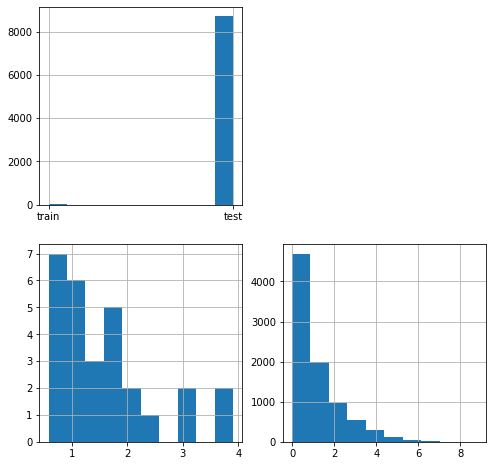

In [27]:
# split 1: train on single mutants (and WT), test on everything else
four_mutations_data['one_vs_rest'] = keep_mask.HD.apply(lambda x: "train" if x <= 1 else "test")

fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(8, 8))
four_mutations_data['one_vs_rest'].hist(ax=ax[0,0])
four_mutations_data.query('one_vs_rest=="train"')['Fitness'].hist(ax=ax[1,0])
four_mutations_data.query('one_vs_rest=="test"')['Fitness'].hist(ax=ax[1,1])
ax[0,1].set_visible(False)

# Randomly pick 10% of train for validation
train_indices = four_mutations_data.query('one_vs_rest=="train"').index
_, val_indices = train_test_split(train_indices, test_size=0.1, random_state=11)
four_mutations_data.loc[val_indices, 'one_vs_rest_validation'] = True

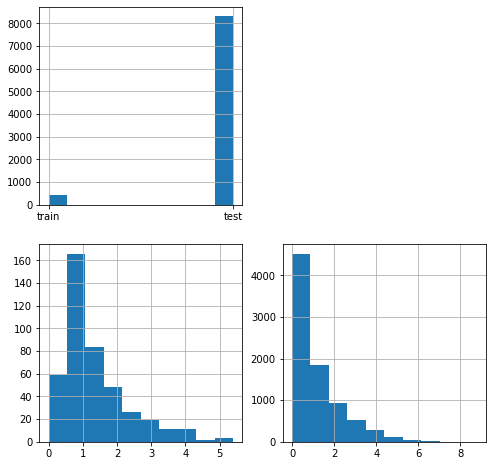

In [28]:
# split 2: train on single & double mutants (and WT), test on everything else
four_mutations_data['two_vs_rest'] = keep_mask.HD.apply(lambda x: "train" if x <= 2 else "test")

fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(8, 8))
four_mutations_data['two_vs_rest'].hist(ax=ax[0,0])
four_mutations_data.query('two_vs_rest=="train"')['Fitness'].hist(ax=ax[1,0])
four_mutations_data.query('two_vs_rest=="test"')['Fitness'].hist(ax=ax[1,1])
ax[0,1].set_visible(False)

# Randomly pick 10% of train for validation
train_indices = four_mutations_data.query('two_vs_rest=="train"').index
_, val_indices = train_test_split(train_indices, test_size=0.1, random_state=11)
four_mutations_data.loc[val_indices, 'two_vs_rest_validation'] = True

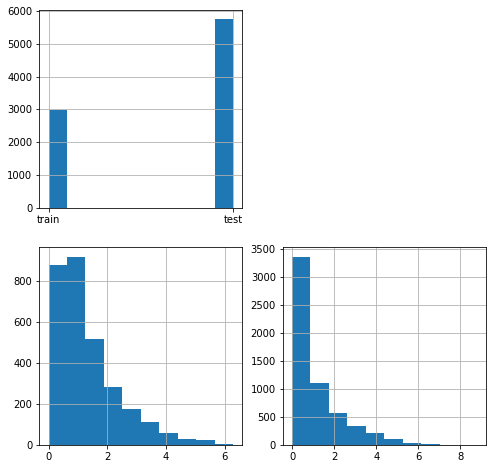

In [29]:
# split 3: train on single, double & triple mutants (and WT), test on everything else
four_mutations_data['three_vs_rest'] = keep_mask.HD.apply(lambda x: "train" if x <= 3 else "test")

fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(8, 8))
four_mutations_data['three_vs_rest'].hist(ax=ax[0,0])
four_mutations_data.query('three_vs_rest=="train"')['Fitness'].hist(ax=ax[1,0])
four_mutations_data.query('three_vs_rest=="test"')['Fitness'].hist(ax=ax[1,1])
ax[0,1].set_visible(False)

# Randomly pick 10% of train for validation
train_indices = four_mutations_data.query('three_vs_rest=="train"').index
_, val_indices = train_test_split(train_indices, test_size=0.1, random_state=11)
four_mutations_data.loc[val_indices, 'three_vs_rest_validation'] = True

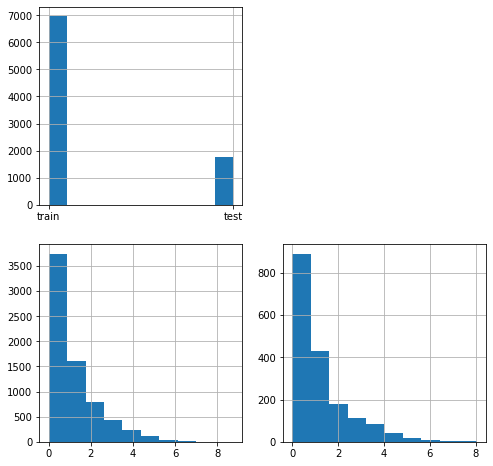

In [30]:
# split 4: random train/test split to 80/20
four_mutations_data['sampled'] = keep_mask.HD.apply(
    lambda x: "train" if random.choices([True, False], weights=[0.8, 0.2], k=1)[0] else "test"
)

fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(8, 8))
four_mutations_data['sampled'].hist(ax=ax[0,0])
four_mutations_data.query('sampled=="train"')['Fitness'].hist(ax=ax[1,0])
four_mutations_data.query('sampled=="test"')['Fitness'].hist(ax=ax[1,1])
ax[0,1].set_visible(False)

# Randomly pick 10% of train for validation
train_indices = four_mutations_data.query('sampled=="train"').index
_, val_indices = train_test_split(train_indices, test_size=0.1, random_state=11)
four_mutations_data.loc[val_indices, 'sampled_validation'] = True

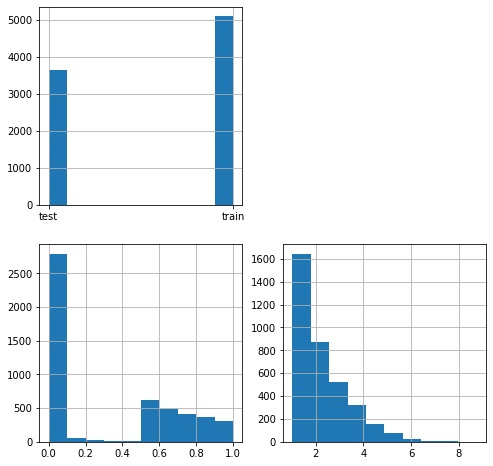

In [31]:
# split 5: train on low scoring, test on high-scoring.
# The high score is given for those sequences with experimental score above WT
four_mutations_data['low_vs_high'] = keep_mask.Fitness.apply(
    lambda x: "train" if x < WT.Fitness else "test"
)

fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(8, 8))
four_mutations_data['low_vs_high'].hist(ax=ax[0,0])
four_mutations_data.query('low_vs_high=="train"')['Fitness'].hist(ax=ax[1,0])
four_mutations_data.query('low_vs_high=="test"')['Fitness'].hist(ax=ax[1,1])
ax[0,1].set_visible(False)

# Randomly pick 10% of train for validation
train_indices = four_mutations_data.query('low_vs_high=="train"').index
_, val_indices = train_test_split(train_indices, test_size=0.1, random_state=11)
four_mutations_data.loc[val_indices, 'low_vs_high_validation'] = True

In [32]:
four_mutations_data.to_csv(split_path / "four_mutations_full_data.csv", index=False)

In [33]:
# split 1
four_mutations_set_1 = four_mutations_data.rename({
    'Fitness': 'target',
    'one_vs_rest': 'set',
    'one_vs_rest_validation': 'validation'
}, axis=1)

four_mutations_set_1.query('keep == True')[
    ['sequence', 'target', 'set']
].to_csv(split_path / 'splits' / "one_vs_rest.csv", index=False)

# split 2
four_mutations_set_2 = four_mutations_data.rename({
    'Fitness': 'target',
    'two_vs_rest': 'set',
    'two_vs_rest_validation': 'validation'
}, axis=1)

four_mutations_set_2.query('keep == True')[
    ['sequence', 'target', 'set']
].to_csv(split_path / 'splits' / "two_vs_rest.csv", index=False)

# split 3
four_mutations_set_3 = four_mutations_data.rename({
    'Fitness': 'target',
    'three_vs_rest': 'set',
    'three_vs_rest_validation': 'validation'
}, axis=1)

four_mutations_set_3.query('keep == True')[
    ['sequence', 'target', 'set']
].to_csv(split_path / 'splits' / "three_vs_rest.csv", index=False)


# split 4
four_mutations_set_4 = four_mutations_data.rename({
    'Fitness': 'target',
    'sampled': 'set',
    'sampled_validation': 'validation'
}, axis=1)

four_mutations_set_4.query('keep == True')[
    ['sequence', 'target', 'set']
].to_csv(split_path / 'splits' / "sampled.csv", index=False)

# split 5
four_mutations_set_5 = four_mutations_data.rename({
    'Fitness': 'target',
    'low_vs_high': 'set',
    'low_vs_high_validation': 'validation'
}, axis=1)

four_mutations_set_5.query('keep == True')[
    ['sequence', 'target', 'set']
].to_csv(split_path / 'splits' / "low_vs_high.csv", index=False)